# Transformer Plot

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
import numpy as np
from tqdm import tqdm, trange
import math
import pandas as pd
import config
from sklearn.preprocessing import MinMaxScaler

# Building the model

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

### Data processing

In [33]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback, pred_steps):
        self.data = torch.FloatTensor(data)
        self.lookback = lookback
        self.pred_steps = pred_steps

    def __len__(self):
        return len(self.data) - self.lookback - self.pred_steps + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.lookback]
        y = self.data[idx+self.lookback:idx+self.lookback+self.pred_steps]
        return x, y


## Defining model

In [34]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward),
            num_encoder_layers
        )
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward),
            num_decoder_layers
        )
        self.input_proj = nn.Linear(input_dim, d_model)
        self.output_proj = nn.Linear(d_model, output_dim)
        
    def forward(self, src, tgt):
        src = self.input_proj(src)
        tgt = self.input_proj(tgt)
        
        # Create mask for decoder
        tgt_mask = self.generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)
        
        memory = self.encoder(src)
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask)
        return self.output_proj(output)
    
    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

## Import data

In [35]:
def normalization(data):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    return data

In [36]:
def load_data(filepath):
    data = pd.read_csv(filepath)
    if 'date' in data.columns:
        data.drop(['date'], axis=1, inplace=True)
    if 'Date' in data.columns:
        data.drop(['Date'], axis=1, inplace=True)
    if 'Adj Close' in data.columns:
        data.drop(['Adj Close'], axis=1, inplace=True)
    if 'Code' in data.columns:
        data.drop(['Code'], axis=1, inplace=True)
    if 'Time' in data.columns:
        data.drop(['Time'], axis=1, inplace=True)
    return data.dropna()

In [37]:
base_dir=config.base_dir
# file_path = base_dir+"/data/iTransformer_datasets/exchange_rate/exchange_rate.csv"
file_path = base_dir+"/data/iTransformer_datasets/traffic/traffic.csv"
data=load_data(file_path)
data=normalization(data)

## Params

In [38]:
# Hyperparameters
lookback = 96 
pred_steps = 18
batch_size = config.batch_size
input_dim = data.shape[1]
output_dim = data.shape[1]
d_model = config.hidden_dim
nhead = config.num_heads
num_encoder_layers = config.transformer_layers
num_decoder_layers = config.transformer_layers
dim_feedforward = config.ffn_dim
num_epochs = 3 
learning_rate = config.learning_rate
weight_decay = config.weight_decay
num_workers = config.num_workers

In [39]:

# Create dataset and dataloader
full_dataset = TimeSeriesDataset(data, lookback, pred_steps)
# Perform train-test split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=False)


# Initialize model
model = TimeSeriesTransformer(
    input_dim=input_dim,
    output_dim=output_dim,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dim_feedforward=dim_feedforward
).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop with tqdm
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, (batch_x, batch_y) in progress_bar:
        optimizer.zero_grad()
        
        # Reshape input: (batch_size, seq_len, input_dim) -> (seq_len, batch_size, input_dim)
        src = batch_x.permute(1, 0, 2).to(device)
        tgt = batch_y.permute(1, 0, 2).to(device)
        
        # Use only the first timestep as initial input
        tgt_input = torch.zeros_like(tgt).to(device)
        tgt_input[0] = src[-1]  # Use the last timestep of input as the first decoder input
        
        output = model(src, tgt_input)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        avg_loss = total_loss / (batch_idx + 1)
        progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})
    
    print(f"Epoch {epoch+1}/{num_epochs} - Average loss: {avg_loss:.4f}")

print("Training completed!")

/home/asdf/miniconda3/envs/d2l/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/3: 100%|██████████| 109/109 [00:03<00:00, 28.13it/s, loss=0.1567]

Epoch 1/3 - Average loss: 0.1567



Epoch 2/3: 100%|██████████| 109/109 [00:03<00:00, 29.94it/s, loss=0.0228]

Epoch 2/3 - Average loss: 0.0228



Epoch 3/3: 100%|██████████| 109/109 [00:03<00:00, 29.85it/s, loss=0.0148]

Epoch 3/3 - Average loss: 0.0148
Training completed!


In [40]:
# Function to make predictions
def predict(model, input_seq, pred_steps):
    model.eval()
    with torch.no_grad():
        src = input_seq.unsqueeze(1).to(device)  # Add batch dimension and move to GPU
        tgt = torch.zeros(pred_steps, 1, input_seq.size(-1)).to(device)
        tgt[0] = src[-1]  # Use the last timestep of input as the first decoder input
        
        for i in range(1, pred_steps):
            output = model(src, tgt[:i])
            tgt[i] = output[-1]
        
    return tgt.squeeze(1).cpu()  # Remove batch dimension and move back to CPU


# Evaluate on test set
def evaluate_loss(model,test_dataloader,criterion,device):
    model.eval()
    total_loss=0
    num_batches = len(test_dataloader)
    
    with torch.no_grad():
        progress_bar = tqdm(enumerate(test_dataloader), total=num_batches, desc="Evaluating")
        for batch_idx, (batch_x, batch_y) in progress_bar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            src = batch_x.permute(1, 0, 2).to(device)
            tgt = batch_y.permute(1, 0, 2).to(device)

            tgt_input = torch.zeros_like(tgt).to(device)
            tgt_input[0] = src[-1]  # Use the last timestep of input as the first decoder input
            
            output = model(src, tgt_input)
            loss = criterion(output, tgt)
            
            total_loss += loss.item()
            avg_loss = total_loss / (batch_idx + 1)
            progress_bar.set_postfix({'avg_loss': f'{avg_loss:.4f}'})
    return total_loss / num_batches

test_loss = evaluate_loss(model,test_dataloader,criterion,device) 

Evaluating: 100%|██████████| 28/28 [00:00<00:00, 45.54it/s, avg_loss=0.0136]


## Plotting

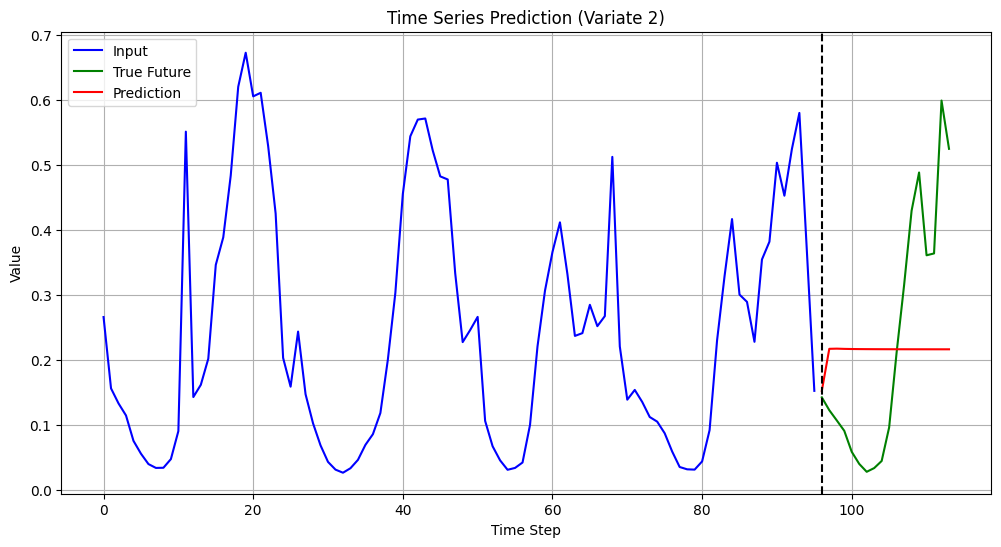

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction(input_seq, true_future, prediction, input_window,variate_index=0 ):
    """
    Plot the input sequence, true future, and prediction for a single variate.
    
    Args:
    - input_seq (torch.Tensor): Input sequence
    - true_future (torch.Tensor): True future values
    - prediction (torch.Tensor): Predicted future values
    - variate_index (int): Index of the variate to plot
    - input_window (int): Number of input time steps to show
    """
    plt.figure(figsize=(12, 6))
    
    # Convert tensors to numpy arrays
    input_seq = input_seq.cpu().numpy()
    true_future = true_future.cpu().numpy()
    prediction = prediction.cpu().numpy()
    
    # Plot input sequence
    plt.plot(range(input_window), input_seq[-input_window:, variate_index], 
             label='Input', color='blue')
    
    # Plot true future
    future_steps = len(true_future)
    plt.plot(range(input_window, input_window + future_steps), 
             true_future[:, variate_index], label='True Future', color='green')
    
    # Plot prediction
    pred_steps = len(prediction)
    plt.plot(range(input_window, input_window + pred_steps), 
             prediction[:, variate_index], label='Prediction', color='red')
    
    plt.axvline(x=input_window, color='k', linestyle='--')
    plt.legend()
    plt.title(f'Time Series Prediction (Variate {variate_index})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# Example usage:
# Assume we have a trained model and a test_dataloader

# Get a sample from the test set
sample_x, sample_y = next(iter(test_dataloader))

# Move to the appropriate device
sample_x = sample_x.to(device)
sample_y = sample_y.to(device)

# Get the last sequence from the batch
input_seq = sample_x[-1]

# Make a prediction
prediction = predict(model, input_seq, pred_steps)

# Plot the result
plot_prediction(input_seq, sample_y[-1], prediction,lookback,variate_index=2)

# If you want to plot a different variate, specify the index
# plot_prediction(input_seq, sample_y[-1], prediction, variate_index=2)